# 08 Replicating papers

In [1]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from going_modular import engine, data_loaders
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = image_path/'train'
test_dir = image_path/'test'

In [5]:
IMG_SIZE = 224
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually Created Transfomrs {manual_transform}')

Manually Created Transfomrs Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_datloader, class_names = data_loaders.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = BATCH_SIZE
)

train_dataloader, test_datloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cc3a22a710>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next (iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

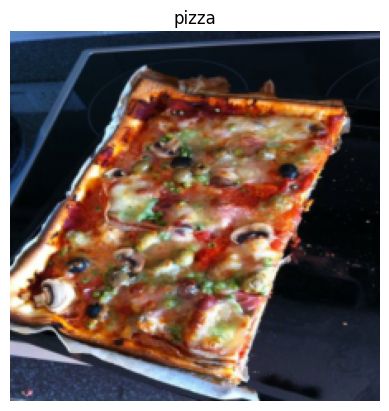

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title (class_names[label])
plt.axis(False)

## 4.1 Caluclating patch embedding

In [15]:
height = 224
width = 225
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/(patch_size **2))
print (f'number patches height (H={height}, width = (W={width}) patch size (P= {patch_size}): {number_of_patches})')

number patches height (H=224, width = (W=225) patch size (P= 16): 196)


In [17]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_input_shape = (number_of_patches, patch_size**2 * color_channels)
print (f'Input Shapem (single 2D imge){embedding_layer_input_shape}')
print (f'Output shape (single 2D image flattened input patches ): {embedding_layer_input_shape}')

Input Shapem (single 2D imge)(196, 768)
Output shape (single 2D image flattened input patches ): (196, 768)


## 4.2 Turning a single image input patches


(-0.5, 223.5, 223.5, -0.5)

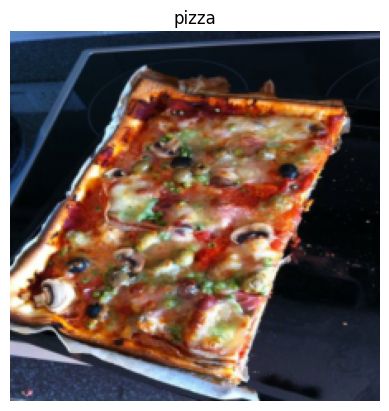

In [18]:
plt.imshow (image.permute(1, 2, 0))
plt.title (class_names[label])
plt.axis (False )

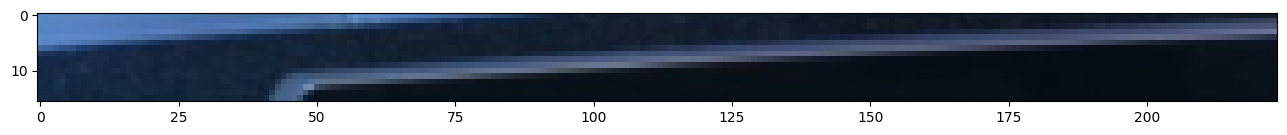

In [19]:
image_permuted = image.permute(1,2, 0)
patch_size= 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patchates pers row: 14.0
Patch size: 16 pixel x 16 pixesl


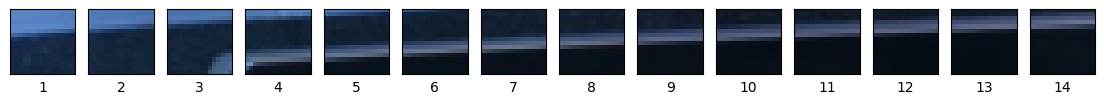

In [24]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisible by patch size"
print (f'Number of patchates pers row: {num_patches}\nPatch size: {patch_size} pixel x {patch_size} pixesl')

fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size// patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True)

for i, patch in enumerate (range (0, img_size, patch_size)):
    axs[i].imshow (image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


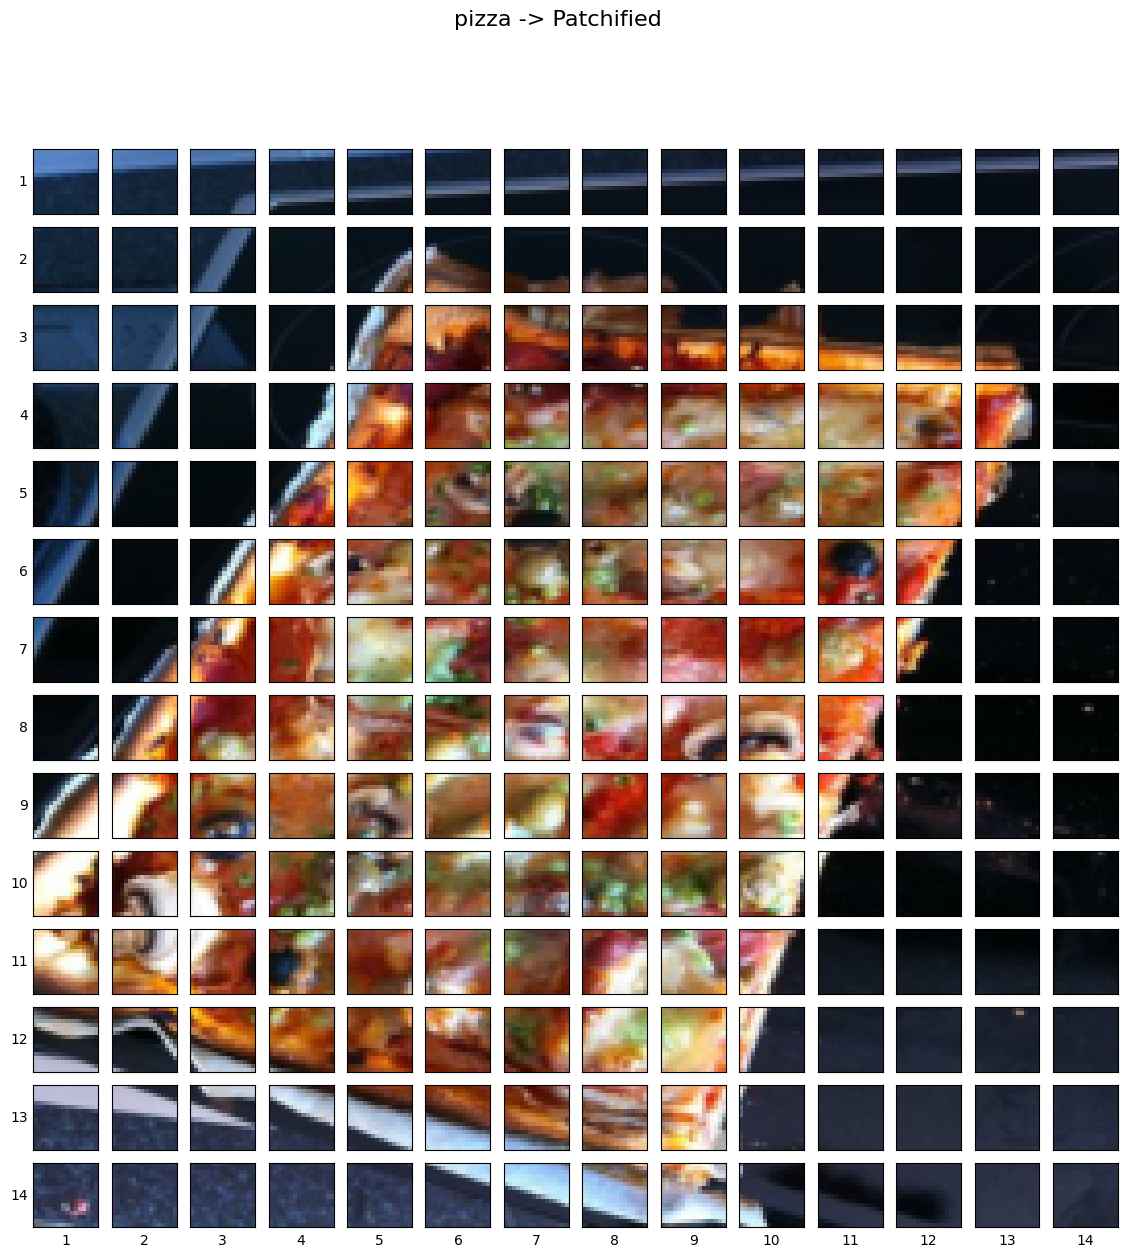

In [34]:
img_size = 224
patch_size = 16
num_patches= img_size/patch_size
assert img_size % patch_size == 0, 'img size nneds'
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots (nrows = img_size//patch_size,
                        ncols = img_size// patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range (0, img_size, patch_size)):
        axs [i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size,
                                         :])
        axs[i, j].set_ylabel (i + 1,
                              rotation = 'horizontal',
                              horizontalalignment = 'right',
                              verticalalignment = 'center')
        axs[i, j].set_xlabel (j + 1)
        axs [i, j].set_xticks([])
        axs [i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchified', fontsize = 16)
plt.show()

## 4.3 Creating image pactecsh with torch.nn.Conv2d()

In [35]:
patch_size = 16
conv2d= nn.Conv2d(in_channels = 3,
                  out_channels = 768,
                  kernel_size = patch_size,
                  stride=patch_size,
                  padding = 0)

(-0.5, 223.5, 223.5, -0.5)

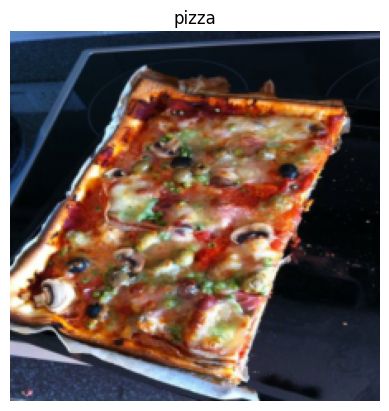

In [38]:
plt.imshow (image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [40]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print (image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

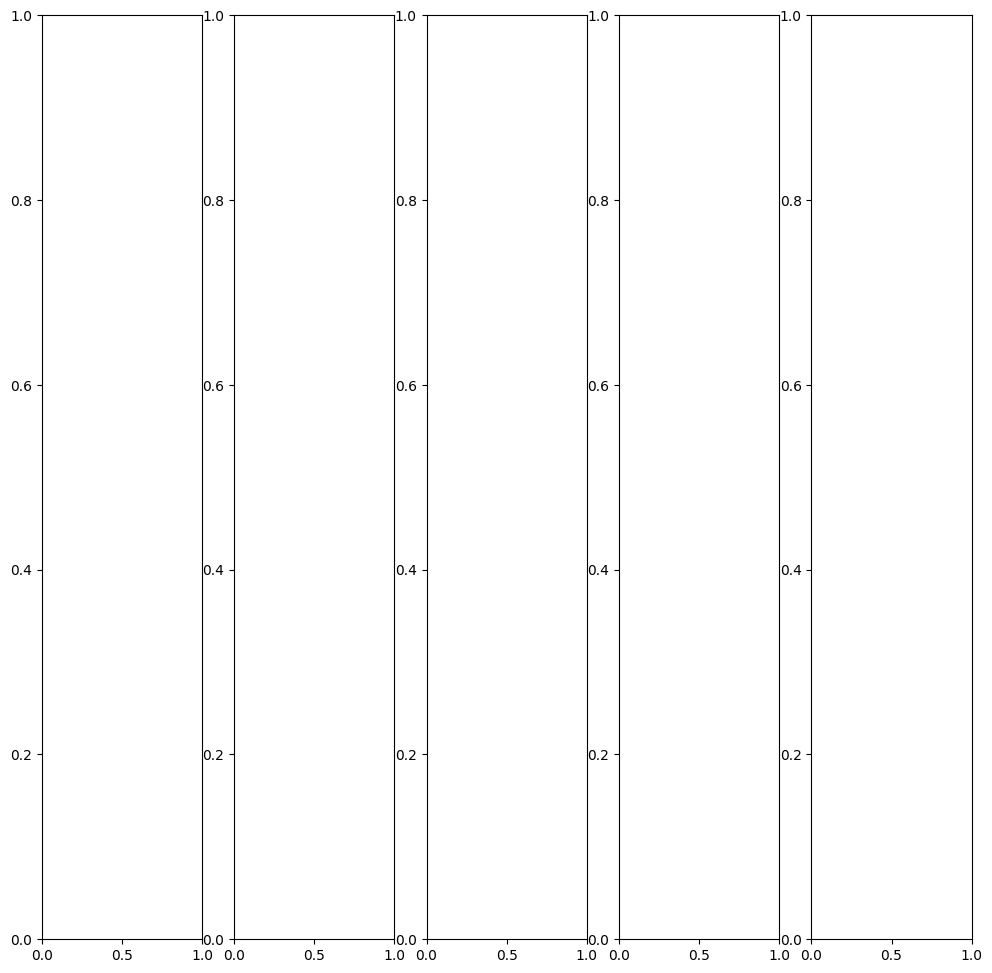

In [42]:
random_indicies = random.sample (range(0, 758), k = 5)
fig, ax = plt.subplots(nrows = 1, ncols =5, figsize = (12, 12))
# for i, idx in enumerate(random_indicies):
#     image_conv_feature_map = image_out_of_conv[:, idx, :]
#     axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
#     axs[i].set(xticklabels = [], yticklabel=[], xticks = [], yticks=[])

for i, idx in enumerate(random_indicies):
    image_conv_feature_map = image_out_of_conv[:, idx, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # Display the image using plt.imshow
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.show() 